In [1]:
import pickle as pkl
import random
import sys
import warnings
from collections import OrderedDict
from glob import glob
from pathlib import Path
from time import time
from typing import Callable, Dict, Optional, Tuple

import brevitas
import brevitas.nn as qnn
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from brevitas import config
from brevitas.quant import Int8ActPerTensorFloat, Int8WeightPerTensorFloat
from concrete.fhe.compilation import Configuration
from sklearn.metrics import top_k_accuracy_score
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm

from concrete.ml.torch.compile import compile_brevitas_qat_model

warnings.filterwarnings("ignore", category=UserWarning)


from cifar_utils import (
    fhe_compatibility,
    get_dataloader,
    mapping_keys,
    plot_baseline,
    plot_dataset,
    torch_inference,
    train,
)

In [2]:
INPUT_IMG_SIZE = 28
NB_LAYER       = 20

<!> Since MNIST is a relatively simple task, training a floating-point model and then fine-tuning the quantized model yields the same results as training the quantized model from scratch.

- If we train first the FP32, then assign the weights to the Brevitas model, and finally finetune it, we save like  10 epochs 

<!> That's why the following cell is disabled.

In [4]:
FEATURES_MAPS = [
    ("I",),
    # Layer 1: INPUT_IMG_SIZE, out_size, kernel_size=t[3], stride=t[4], padding=t[5], padding_mode="replicate")
    ("C", 1, 1, 3, 1, 1, "replicate"),
]

# In the paper, we have 17 identity layers (frozen layers)
LINEAR_LAYERS = (
    [("R",), ("L", INPUT_IMG_SIZE * INPUT_IMG_SIZE, 92),  ("I",), ("B", 92), ("I",),] + \
    [("R",), ("L", 92, 92),  ("I",), ("B", 92), ("I",),] * (NB_LAYER - 2) + [("L", 92, 10)]
)

In [5]:
class Fp32MNIST(nn.Module):
    def __init__(self, output_size: int):
        super(Fp32MNIST, self).__init__()
        """ Torch model.

        Args:
            output_size (int): Number of classes.
        """
        self.output_size = output_size

        def make_layers(t):

            if t[0] == "C":
                return nn.Conv2d(t[1], t[2], kernel_size=t[3], stride=t[4], padding=t[5], padding_mode=t[6])
            elif t[0] == "L":
                return nn.Linear(in_features=t[1], out_features=t[2])
            elif t[0] == "R":
                return nn.ReLU()
            elif t[0] == "F":
                return nn.Flatten(1, -1)
            elif t[0]:
                return nn.BatchNorm1d(t[1])
            else:
                raise NameError(f"{t} not defined")

        self.features_maps = nn.Sequential(*[make_layers(t) for t in FEATURES_MAPS if t[0] != "I"])
        self.linears = nn.Sequential(*[make_layers(t) for t in LINEAR_LAYERS if t[0] != "I"])

    def forward(self, x):
        x = self.features_maps(x)
        x = nn.Flatten()(x)
        x = self.linears(x)
        return x

In [6]:
class QuantMNIST(nn.Module):
    def __init__(
        self,
        bit: int,
        output_size: int = 10,
        act_quant: brevitas.quant = Int8ActPerTensorFloat,
        weight_quant: brevitas.quant = Int8WeightPerTensorFloat,
    ):
        """A quantized network with Brevitas.

        Args:
            bit (int): Bit of quantization.
            output_size (int): Number of classes.
            act_quant (brevitas.quant): Quantization protocol of activations.
            weight_quant (brevitas.quant): Quantization protocol of the weights.

        """
        super(QuantMNIST, self).__init__()
        self.bit = bit

        def tuple2quantlayer(t):
            if t[0] == "R":
                return qnn.QuantReLU(return_quant_tensor=True, bit_width=bit, act_quant=act_quant)
            if t[0] == "C":
                return qnn.QuantConv2d(
                    t[1],
                    t[2],
                    kernel_size=t[3],
                    stride=t[4],
                    padding=t[5],
                    weight_bit_width=2,
                    weight_quant=weight_quant,
                    return_quant_tensor=True,
                )
            if t[0] == "L":
                return qnn.QuantLinear(
                    in_features=t[1],
                    out_features=t[2],
                    weight_bit_width=bit,
                    weight_quant=weight_quant,
                    bias=True,
                    return_quant_tensor=True,
                )
            if t[0] == "I":
                identity_quant = t[1] if len(t) == 2 else bit
                return qnn.QuantIdentity(
                    bit_width=identity_quant, act_quant=act_quant, return_quant_tensor=True
                )
            if t[0] == "B":
                return nn.BatchNorm1d(t[1])

        self.features_maps = nn.Sequential(
            *[tuple2quantlayer(t) for t in FEATURES_MAPS if t[0] != "I"]
        )

        # self.identity1 and self.identity2 are used to encapsulate the `torch.flatten`.
        self.identity1 = qnn.QuantIdentity(
            bit_width=bit, act_quant=act_quant, return_quant_tensor=True
        )

        self.identity2 = qnn.QuantIdentity(
            bit_width=bit, act_quant=act_quant, return_quant_tensor=True
        )

        self.linears = nn.Sequential(*[tuple2quantlayer(t) for t in LINEAR_LAYERS if t[0] != "I"])

    def forward(self, x):
        x = self.features_maps(x)
        x = self.identity1(x)
        x = torch.flatten(x, 1)
        x = self.identity2(x)
        x = self.linears(x)
        return x.value

Train the model

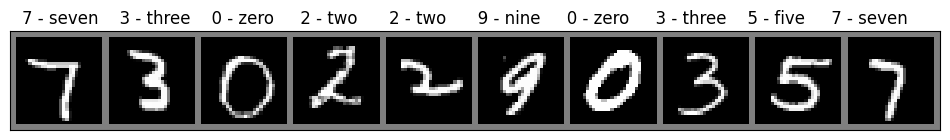

torch.Size([64, 1, 28, 28])

In [20]:
param = {
    "output_size": 10,
    "batch_size": 64,
    "dataset_name": "MNIST",
    "dataset": datasets.MNIST,
    "dir": "./checkpoints/MNIST_V737",
    "training": "fp32",
    "criterion": torch.nn.CrossEntropyLoss(),
    "accuracy_test": [],
    "accuracy_train": [],
    "loss_test_history": [],
    "loss_train_history": [],
    "seed": 42,
}

def fhe_compatibility(model, data, rounding, show_mlir=False):

    qmodel = compile_brevitas_qat_model(
        model.to("cpu"),
        # Training
        torch_inputset=data,
        show_mlir=show_mlir,
        output_onnx_file=f"{param['dir']}/test.onnx",
        rounding_threshold_bits=rounding
    )

    return qmodel

device =  "cpu"

train_loader, test_loader = get_dataloader(param=param)

data_calibration, _ = next(iter(train_loader))

plot_dataset(test_loader, param)

for x, y in train_loader:
    break

x.shape

In [14]:
# Instantiation of the custom VGG-11 network.

run = False

fp32_mnist = Fp32MNIST(param['output_size']).to(device)

# # # We freeze all the layers.
# for n, p in list(fp32_mnist.named_parameters())[4: -2]:
#         p.requires_grad = False
#         #print(n, p.requires_grad)

# # # We freeze all the layers.
# for n, p in fp32_mnist.named_parameters():
#         print(n, p.requires_grad)

if run:
    param["training"] = "fp32_mnist"
    param["epochs"] = 30
    param["lr"] = 0.01
    param["milestones"] = [15, 24]
    param["gamma"] = 0.1

    fp32_mnist = train(fp32_mnist, train_loader, test_loader, param, device=device)

Epoch  0: Train loss = 0.7042 VS Test loss = 0.3664 - Accuracy train: 0.7837 VS Accuracy test: 0.9075
Epoch  1: Train loss = 0.3901 VS Test loss = 0.3454 - Accuracy train: 0.9058 VS Accuracy test: 0.9226
Epoch  2: Train loss = 0.3086 VS Test loss = 0.2445 - Accuracy train: 0.9263 VS Accuracy test: 0.9449
Epoch  3: Train loss = 0.2944 VS Test loss = 0.3041 - Accuracy train: 0.9290 VS Accuracy test: 0.9504
Epoch  4: Train loss = 0.2460 VS Test loss = 0.2034 - Accuracy train: 0.9417 VS Accuracy test: 0.9606
Epoch  5: Train loss = 0.2267 VS Test loss = 0.1726 - Accuracy train: 0.9469 VS Accuracy test: 0.9564
Epoch  6: Train loss = 0.2049 VS Test loss = 0.2818 - Accuracy train: 0.9518 VS Accuracy test: 0.9585
Epoch  7: Train loss = 0.1959 VS Test loss = 0.2047 - Accuracy train: 0.9529 VS Accuracy test: 0.9605
Epoch  8: Train loss = 0.1805 VS Test loss = 0.2554 - Accuracy train: 0.9561 VS Accuracy test: 0.9655
Epoch  9: Train loss = 0.1678 VS Test loss = 0.1792 - Accuracy train: 0.9596 VS Ac

In [8]:
path_fp32 = f"{param['dir']}/fp32_mnist/MNIST_fp32_mnist_state_dict.pt"
checkpoint_fp32 = torch.load(path_fp32, map_location=device)

fp32_mnist = Fp32MNIST(param['output_size']).to(device)

fp32_mnist.load_state_dict(checkpoint_fp32)

torch_inference(fp32_mnist, test_loader, device=device), torch_inference(fp32_mnist, train_loader, device=device), list(checkpoint_fp32.keys())[:10]

(0.9809695512820513,
 0.9940801760939167,
 ['features_maps.0.weight',
  'features_maps.0.bias',
  'linears.1.weight',
  'linears.1.bias',
  'linears.2.weight',
  'linears.2.bias',
  'linears.2.running_mean',
  'linears.2.running_var',
  'linears.2.num_batches_tracked',
  'linears.4.weight'])

In [21]:
bits = 4

quant_mnist = QuantMNIST(bit=bits, output_size=param["output_size"]).to("cpu")

quant_mnist = mapping_keys(checkpoint_fp32, quant_mnist, device="cpu")

acc_before_ft = torch_inference(quant_mnist, test_loader, device=device)

print(f"Top 1 accuracy before fine-tuning = {acc_before_ft * 100:.4f}%")

qmodel = fhe_compatibility(quant_mnist, data_calibration, rounding=4, show_mlir=True)

print(f"Maximum bit-width in the circuit: {qmodel.fhe_circuit.graph.maximum_integer_bit_width()}")

Top 1 accuracy before fine-tuning = 9.7957%

MLIR
--------------------------------------------------------------------------------
module {
  func.func @main(%arg0: tensor<1x1x28x28x!FHE.esint<11>>) -> tensor<1x10x!FHE.esint<11>> {
    %c1_i12 = arith.constant 1 : i12
    %0 = "FHE.zero_tensor"() : () -> tensor<1x1x30x30x!FHE.eint<11>>
    %from_elements = tensor.from_elements %c1_i12 : tensor<1xi12>
    %1 = "FHELinalg.add_eint_int"(%0, %from_elements) : (tensor<1x1x30x30x!FHE.eint<11>>, tensor<1xi12>) -> tensor<1x1x30x30x!FHE.eint<11>>
    %c0_i2 = arith.constant 0 : i2
    %from_elements_0 = tensor.from_elements %c0_i2 : tensor<1xi2>
    %2 = "FHELinalg.mul_eint_int"(%1, %from_elements_0) : (tensor<1x1x30x30x!FHE.eint<11>>, tensor<1xi2>) -> tensor<1x1x30x30x!FHE.eint<11>>
    %3 = "FHELinalg.to_signed"(%2) : (tensor<1x1x30x30x!FHE.eint<11>>) -> tensor<1x1x30x30x!FHE.esint<11>>
    %inserted_slice = tensor.insert_slice %arg0 into %3[0, 0, 1, 1] [1, 1, 28, 28] [1, 1, 1, 1] : tensor<1x

In [22]:
if True:
    param["training"] = f"quant_mnist_{bits=}"
    param["epochs"] = 5
    param["lr"] = 0.1
    param["milestones"] = [1, 3]
    param["gamma"] = 0.1

    quant_mnist = train(quant_mnist, train_loader, test_loader, param, device=device)


Epoch  0: Train loss = 0.6197 VS Test loss = 0.3243 - Accuracy train: 0.8582 VS Accuracy test: 0.9355
Epoch  1: Train loss = 0.2506 VS Test loss = 0.1684 - Accuracy train: 0.9438 VS Accuracy test: 0.9637
Epoch  2: Train loss = 0.1987 VS Test loss = 0.1910 - Accuracy train: 0.9551 VS Accuracy test: 0.9678
Epoch  3: Train loss = 0.1650 VS Test loss = 0.1630 - Accuracy train: 0.9618 VS Accuracy test: 0.9663
Epoch  4: Train loss = 0.1557 VS Test loss = 0.1335 - Accuracy train: 0.9629 VS Accuracy test: 0.9724
100%|██████████| 5/5 [05:22<00:00, 64.50s/it]


In [ ]:
path_quant = "./checkpoints/MNIST_V737/quant_mnist_bits=5/MNIST_quant_mnist_bits=5_state_dict.pt"
checkpoint_quant = torch.load(path_quant, map_location=device)

quant_mnist = QuantMNIST(param['output_size']).to(device)

quant_mnist.load_state_dict(checkpoint_quant)

torch_inference(quant_mnist, test_loader, device=device), torch_inference(quant_mnist, train_loader, device=device), list(checkpoint_quant.keys())[:10]

In [23]:
qmodel = fhe_compatibility(quant_mnist, data_calibration, rounding=bits, show_mlir=True)

print(f"Maximum bit-width in the circuit: {qmodel.fhe_circuit.graph.maximum_integer_bit_width()}")


MLIR
--------------------------------------------------------------------------------
module {
  func.func @main(%arg0: tensor<1x1x28x28x!FHE.esint<11>>) -> tensor<1x10x!FHE.esint<14>> {
    %c1_i12 = arith.constant 1 : i12
    %0 = "FHE.zero_tensor"() : () -> tensor<1x1x30x30x!FHE.eint<11>>
    %from_elements = tensor.from_elements %c1_i12 : tensor<1xi12>
    %1 = "FHELinalg.add_eint_int"(%0, %from_elements) : (tensor<1x1x30x30x!FHE.eint<11>>, tensor<1xi12>) -> tensor<1x1x30x30x!FHE.eint<11>>
    %c0_i2 = arith.constant 0 : i2
    %from_elements_0 = tensor.from_elements %c0_i2 : tensor<1xi2>
    %2 = "FHELinalg.mul_eint_int"(%1, %from_elements_0) : (tensor<1x1x30x30x!FHE.eint<11>>, tensor<1xi2>) -> tensor<1x1x30x30x!FHE.eint<11>>
    %3 = "FHELinalg.to_signed"(%2) : (tensor<1x1x30x30x!FHE.eint<11>>) -> tensor<1x1x30x30x!FHE.esint<11>>
    %inserted_slice = tensor.insert_slice %arg0 into %3[0, 0, 1, 1] [1, 1, 28, 28] [1, 1, 1, 1] : tensor<1x1x28x28x!FHE.esint<11>> into tensor<1x1x30x3

2

key swith diminue la compression mais pas autant que la compression feature

(1, 28, 28)

In [44]:
data_calibration, _ = next(iter(train_loader))

history = {}

for thresold in range(quant_mnist.bit, 2, -1):
    history_yhats, history_timing = [], []
    run_in_fhe = 0

    for data, labels in tqdm(test_loader):

        data, labels = data.detach().cpu().numpy(), labels.detach().cpu().numpy()

        history[thresold] = []

        qmodel = compile_brevitas_qat_model(
            quant_mnist.to("cpu"),
            torch_inputset=data_calibration,
            rounding_threshold_bits=thresold,
        )
        start_time = time()
        predictions = qmodel.forward(data, fhe="simulate")
        end_time = ((time() - start_time) / 60.0) / data.shape[0]
        history_yhats.extend(predictions.argmax(1) == labels)
        history_timing.append(end_time)
        if run_in_fhe  == 0:
            start_time = time()
            predictions = qmodel.forward(data[0, None], fhe="execute")
            end_time = ((time() - start_time) / 60.0) / data.shape[0]
            history_timing.append(end_time)
            run_in_fhe += 1
            print(history_timing)
        # except:
        #     print(thresold)

        #     history_yhats.extend("None")
        #     history_timing.append("None")

    history[thresold].append([history_yhats, history_timing])

  1%|          | 1/156 [01:19<3:24:27, 79.15s/it]

[0.000280592901011308, 0.018736712510387103]


  1%|          | 1/156 [01:26<3:42:25, 86.10s/it]

[0.0002752001707752546, 0.02072607638935248]


 53%|█████▎    | 83/156 [10:50<08:26,  6.93s/it] 

In [41]:
data[0, None].shape

(1, 1, 28, 28)

avant approximate, 
batch norm () | mettre constante batch norm dans les relu - 
auto encoder - raleng"é le reseau  |


pip probleme de taille, 


In [25]:
quant_mnist.bit

4

In [ ]:
#auto rounding

In [31]:
for threshold in history.keys():
    print(
        f"{quant_mnist.bit=} - {threshold=}: accuracy = {np.mean(history[threshold][0][0]):.3f}, {np.mean(history[threshold][0][1]):.3f}"
    )

quant_mnist.bit=4 - threshold=4: accuracy = 0.938, 0.000
quant_mnist.bit=4 - threshold=3: accuracy = 0.554, 0.000


Privacy-preserving ChatGPT witth Encrypted anonymization
using Fully Homomorphic Encryption